In [1]:
!pip install SimpleITK

!pip install opencv-python

!pip install matplotlib

!pip install pillow

!pip install scikit-learn

!pip install scikit-image 

!pip install scipy

!pip install numpy

     |████████████████████████████████| 42.5MB 72kB/s 


#Libraries imports

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'svg'

import io
from google.colab import files

#Data load

In [3]:
test_csv_format = files.upload()

Saving emnist-letters-test.csv to emnist-letters-test.csv


In [4]:
train_csv_format = files.upload()

Saving emnist-letters-train.csv to emnist-letters-train.csv


In [5]:
#checking connection to GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#spliting of the data

In [6]:
# split the training and testing data into X (image) and Y (label) arrays
test_df = pd.read_csv(io.StringIO(test_csv_format['emnist-letters-test.csv'].decode('utf-8')))
train_df = pd.read_csv(io.StringIO(train_csv_format['emnist-letters-train.csv'].decode('utf-8')))

train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

x_train = train_data[:, 1:] / 255
x_train = np.array(list(map(lambda x: x.reshape(28,28).transpose() ,x_train)))
y_train = train_data[:, 0]
y_train = np.array(list(map(lambda x: x-1, y_train.flatten())))

x_test = test_data[:, 1:] / 255
x_test = np.array(list(map(lambda x: x.reshape(28,28).transpose() ,x_test)))
y_test = test_data[:, 0]
y_test = np.array(list(map(lambda x: x-1, y_test.flatten())))

#split the train data into two data sets of train and validation
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.1, random_state=12345,
)

# reshape the data back into image representation
im_rows = 28
im_cols = 28
batch_size = 512
im_shape = (im_rows, im_cols)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

print("train set size : {} \n".format(x_train.shape[0]))
print("validation set size : {} \n".format(x_validate.shape[0]))
print("test set size : {} \n".format(x_test.shape[0]))

train set size : 79919 

validation set size : 8880 

test set size : 14799 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

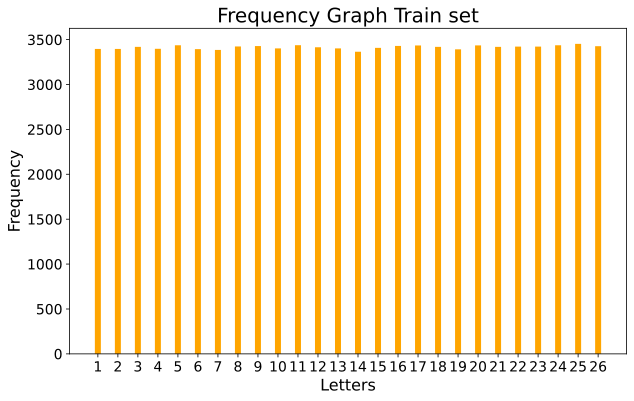

In [7]:
# Cheacking frequency of Letters in training and validation set

# counts training set
counts = train_df.groupby('23')['23'].count()

f = plt.figure(figsize=(10,6))
f.add_subplot(111)

#plot
plt.bar(counts.index,counts.values,width = 0.3,color="orange")
plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Letters",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph Train set",fontsize=20)
plt.savefig('Letters_frequency_train.png')
files.download("Letters_frequency_train.png")
plt.show()


#Generate Perlin noise

In [8]:
def generate_perlin_noise_2d(shape, res, tileable=(False, False)):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

#Add the noise to the Dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

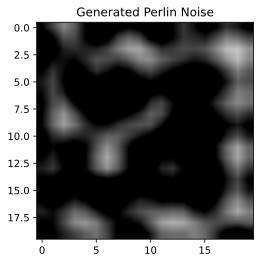

In [9]:

# divide data to train, validate and tests sets 
datasets=[x_train, x_validate, x_test]
noise_dataset=[]

# weights
w_img=0.25
w_noise=1-w_img

# Before adding the noise to the data, plot an example of the generated noise
noise = (generate_perlin_noise_2d((20,20), (5,5)))
plt.imshow(noise, cmap='gray',vmin=0,vmax=1, interpolation='bilinear')
a=plt.title("Generated Perlin Noise")

index = 0

for dataset in datasets:
  noise_dataset.append(dataset.copy())
  dataset_size = dataset.shape[0]
  for j in range(0,dataset_size):
    perlin_noise = generate_perlin_noise_2d((28, 28), (4, 4))
    noise_dataset[index][j] = w_img * noise_dataset[index][j] + w_noise * perlin_noise 
  index = index + 1

plt.savefig('perlin_noise_example.png')
files.download("perlin_noise_example.png")

#printing of the the clean and noisy data set with labels 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

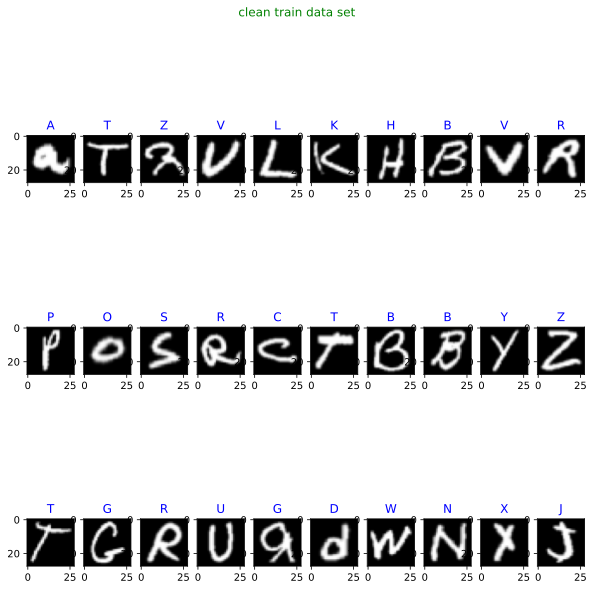

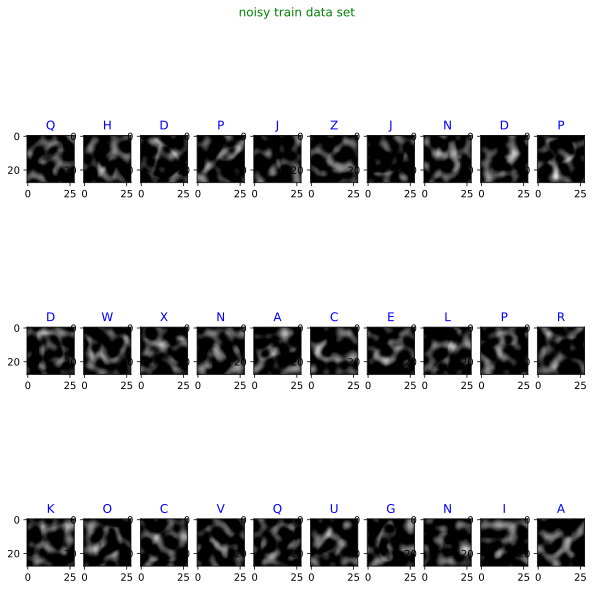

In [11]:
# for converting labels-numbers to labels-names
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

figure = plt.figure(figsize=(10,10))
plt.suptitle("clean train data set",color='g')
counter=1
for j in np.random.choice(np.arange(0, len(y_train)), size=30):
    
    plt.subplot(3, 10, counter)
    counter+=1
    plt.imshow(np.squeeze(x_train[j]),cmap='gray',vmin=0, vmax=1)
    plt.title(labels[int(y_train[j])],color = 'b')

figure2 = plt.figure(figsize=(10,10))
plt.suptitle("noisy train data set",color='g')
counter=1
for j in np.random.choice(np.arange(0, len(y_train)), size=30):
    
    plt.subplot(3, 10, counter)
    counter+=1
    plt.imshow(np.squeeze(noise_dataset[0][j]),cmap='gray',vmin=0, vmax=1)
    plt.title(labels[int(y_train[j])],color = 'b')

 #saving the results  
figure.savefig('clean_data_set.png')
files.download("clean_data_set.png")

figure2.savefig('noisy_data_set.png')
files.download("noisy_data_set.png")



#CNN model definitaion and configuration

In [12]:
model = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1), kernel_initializer='he_normal', name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.25, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Conv2D(128, kernel_size=3, activation='relu', name='Conv2D-3'),
    Dropout(0.25, name='Dropout-3'),
   
    Flatten(name='flatten'),
   
    Dense(256, activation='relu', name='Dense'),
    Dropout(0.4, name='Dropout-4'),
    Dense(128, activation='relu', name='Dense-1'),
    Dropout(0.4, name='Dropout-5'),
    Dense(26, activation='softmax', name='Output')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 13, 13, 32)        0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
Dropout-2 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
Conv2D-3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
Dropout-3 (Dropout)          (None, 9, 9, 128)         0

In [15]:
history = model.fit(
    np.expand_dims(noise_dataset[0],axis=-1), y_train, #expend for '3D'
    batch_size=batch_size,
    epochs=50,
    validation_data=(np.expand_dims(noise_dataset[1],axis=-1), y_validate))

Epoch 1/50
157/157 [==============================] - 3s 22ms/step - loss: 2.8614 - accuracy: 0.1646 - val_loss: 2.1349 - val_accuracy: 0.3953
Epoch 2/50
157/157 [==============================] - 3s 21ms/step - loss: 2.1363 - accuracy: 0.3653 - val_loss: 1.5528 - val_accuracy: 0.5265
Epoch 3/50
157/157 [==============================] - 3s 21ms/step - loss: 1.6188 - accuracy: 0.5078 - val_loss: 1.0154 - val_accuracy: 0.7008
Epoch 4/50
157/157 [==============================] - 3s 21ms/step - loss: 1.3045 - accuracy: 0.5959 - val_loss: 0.8236 - val_accuracy: 0.7452
Epoch 5/50
157/157 [==============================] - 3s 21ms/step - loss: 1.1149 - accuracy: 0.6504 - val_loss: 0.7463 - val_accuracy: 0.7637
Epoch 6/50
157/157 [==============================] - 3s 21ms/step - loss: 0.9924 - accuracy: 0.6911 - val_loss: 0.6198 - val_accuracy: 0.8011
Epoch 7/50
157/157 [==============================] - 3s 21ms/step - loss: 0.9025 - accuracy: 0.7160 - val_loss: 0.5667 - val_accuracy: 0.8176

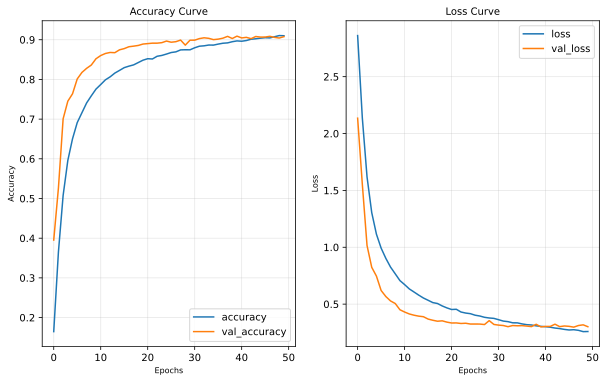

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Diffining Figure
f = plt.figure(figsize=(10,6))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history.epoch,history.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history.epoch,history.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=10)
plt.xlabel("Epochs",fontsize=8)
plt.ylabel("Accuracy",fontsize=8)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=10)
plt.xlabel("Epochs",fontsize=8)
plt.ylabel("Loss",fontsize=8)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

f.savefig('validation_loss_accuracy.png')
files.download("validation_loss_accuracy.png")

#Model testing

In [18]:
loss,acc = model.evaluate(np.expand_dims(noise_dataset[2],axis=-1), y_test,batch_size=batch_size) 
print("accuracy on noise test data set: {}".format(acc))
print("loss on noise test data set: {}".format(loss))

29/29 [==============================] - 0s 10ms/step - loss: 0.3309 - accuracy: 0.8978
accuracy on noise test data set: 0.8977633714675903
loss on noise test data set: 0.33089810609817505


In [19]:

val_predict =  np.argmax(model.predict(np.expand_dims(noise_dataset[2],axis =-1)), axis=1)
error = 0
confusion_matrix = np.zeros([26,26])

for i in range(y_test.shape[0]):
    confusion_matrix[int(y_test[i]),int(val_predict[i])] += 1
    if y_test[i]!=val_predict[i]:
        error +=1
        

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in testing set: " ,error)
print("\nError Persentage : " ,(error*100)/val_predict.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_predict.shape[0])
print("\nTesting set size :",val_predict.shape[0])


Confusion Matrix: 

 [[708.   2.   2.   9.   8.   0.   5.   8.   0.   0.   2.   0.   1.   7.
   13.   1.  16.   1.   3.   1.   2.   0.   1.   1.   0.   8.]
 [  1. 767.   0.   1.   4.   0.   5.   4.   1.   0.   0.   4.   0.   1.
    2.   0.   1.   3.   3.   1.   0.   0.   0.   0.   0.   2.]
 [  2.   1. 734.   1.  34.   0.   1.   0.   1.   0.   0.   2.   0.   0.
   15.   0.   0.   2.   1.   0.   3.   0.   1.   0.   0.   2.]
 [  6.   9.   0. 723.   0.   0.   0.   2.   0.   4.   0.   0.   0.   1.
   43.   6.   1.   0.   0.   1.   2.   0.   1.   1.   0.   0.]
 [  3.   1.  21.   0. 753.   1.   4.   0.   0.   0.   1.   2.   0.   0.
    1.   2.   0.   4.   4.   1.   0.   1.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   4. 748.   6.   0.   2.   0.   0.   0.   0.   0.
    0.  20.   0.   4.   2.  13.   0.   0.   0.   1.   0.   0.]
 [ 15.  20.   8.   1.   7.   2. 608.   1.   0.   8.   0.   1.   0.   2.
    4.   1. 104.   0.  10.   0.   2.   0.   0.   1.   5.   0.]
 [  5.   5.   0.   0.   0.   0.   

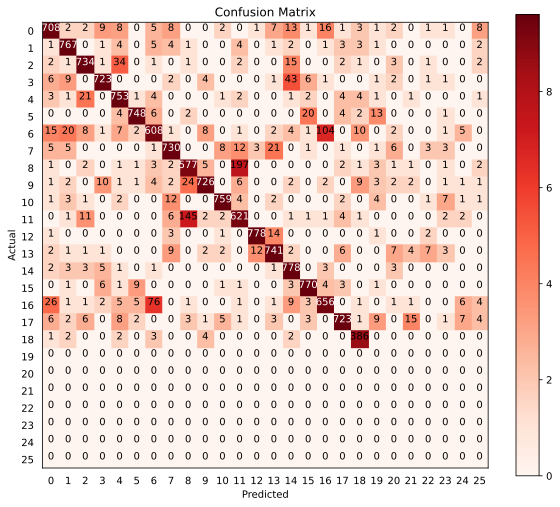

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,26),np.arange(0,26))
plt.yticks(np.arange(0,26),np.arange(0,26))

threshold = confusion_matrix.max()/2 

for i in range(26):
    for j in range(26):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")
        
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix.png")
plt.show()

files.download("Confusion_matrix.png")



#Model test data results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

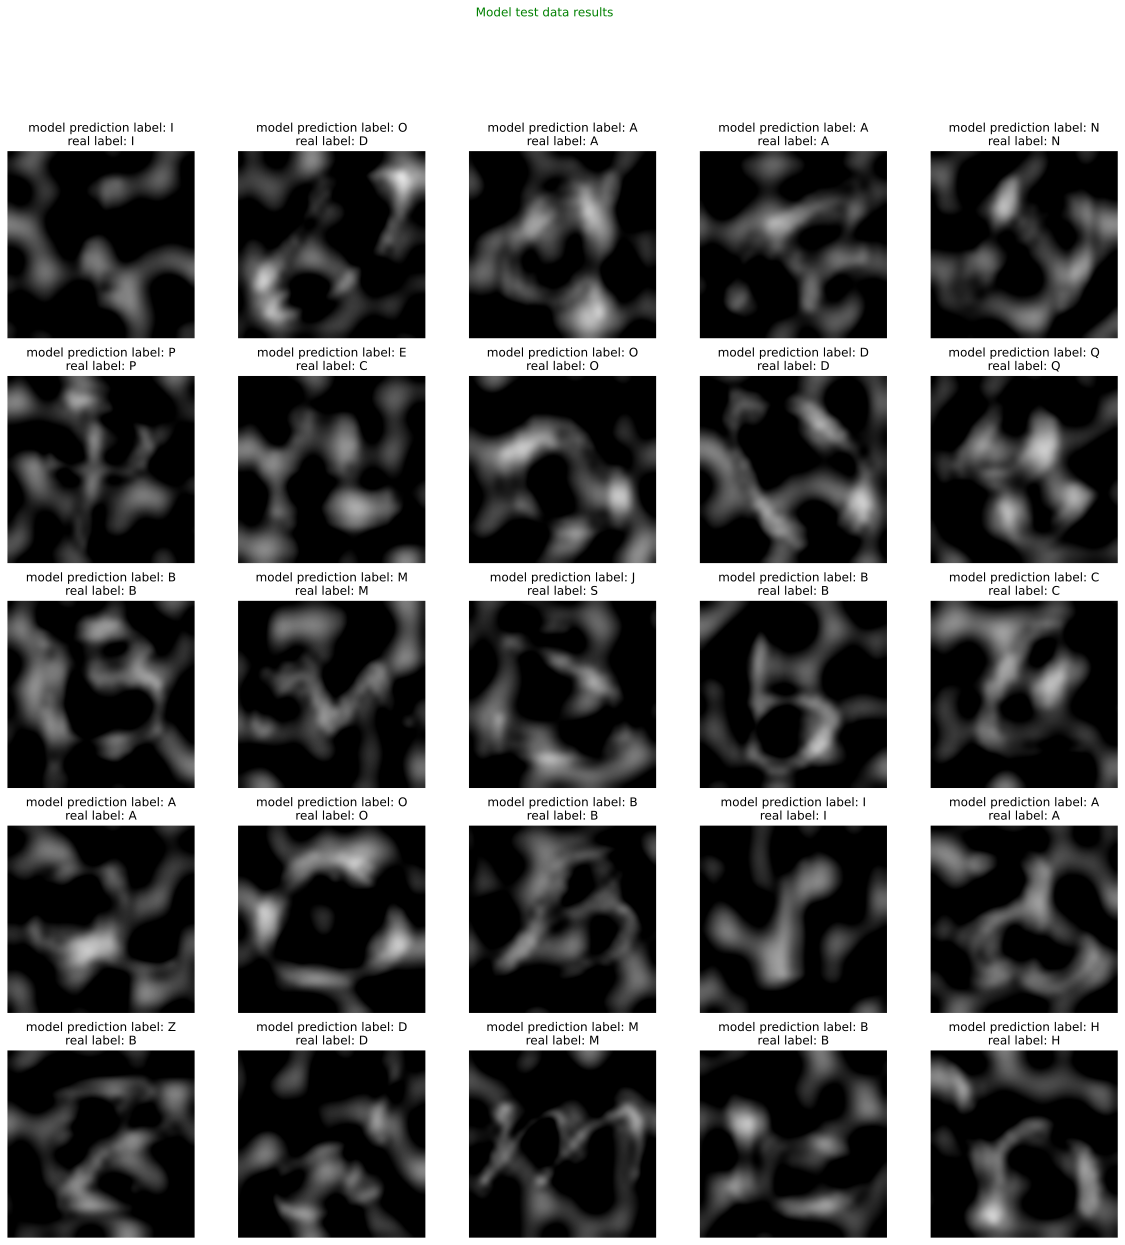

In [22]:
figure = plt.figure(figsize=(20,20))
plt.suptitle("Model test data results",color='g')
counter=1
for i in np.random.choice(np.arange(0, len(y_test)), size=25):
    plt.subplot(5, 5, counter)
    counter+=1
    plt.axis('off')
    plt.imshow(noise_dataset[2][i],cmap='gray',vmin=0, vmax=1,interpolation='lanczos')
    plt.title("model prediction label: " + labels[int(val_predict[i])] + "\n" + "real label: " + labels[int(y_test[i])])

figure.savefig('Model test data results.PNG')    
files.download("Model test data results.PNG")